In [1]:
import torch
from torch import nn
import os
from tqdm import tqdm_notebook
from PIL import Image
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class CelebaDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, landmarks_dir, transform, train=True):
        super(CelebaDataset, self).__init__()
        self.images_dir = images_dir
        self.landmarks_dir = landmarks_dir
        if train:
            self.landmarks = os.listdir(self.landmarks_dir)[:190000]
        else:
            self.landmarks = os.listdir(self.landmarks_dir)[190000:]
        self.transform = transform
    def __len__(self):
        return len(self.landmarks)
    def __getitem__(self, idx):
        filename = self.landmarks[idx]
        landmark = torch.from_numpy(np.loadtxt(self.landmarks_dir + filename))       
        image = Image.open(f'{self.images_dir}{filename[:-4]}.jpg')
        landmark[:, 0] /= image.size[0]
        landmark[:, 1] /= image.size[1]
        image = self.transform(image)
        return image, landmark
    
class TinyCelebaDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, landmarks_dir, transform, train=True):
        super(TinyCelebaDataset, self).__init__()
        self.images_dir = images_dir
        self.landmarks_dir = landmarks_dir
        if train:
            self.landmarks = os.listdir(self.landmarks_dir)[:15000]
        else:
            self.landmarks = os.listdir(self.landmarks_dir)[15000:17500]
        self.transform = transform
    def __len__(self):
        return len(self.landmarks)
    def __getitem__(self, idx):
        filename = self.landmarks[idx]
        landmark = torch.from_numpy(np.loadtxt(self.landmarks_dir + filename))       
        image = Image.open(f'{self.images_dir}{filename[:-4]}.jpg')
        landmark[:, 0] /= image.size[0]
        landmark[:, 1] /= image.size[1]
        image = self.transform(image)
        return image, landmark

In [3]:
IMAGE_SIZE = 128
transforms = torchvision.transforms.Compose((
    torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),      
    torchvision.transforms.ToTensor()
))
train_dataset = TinyCelebaDataset('./img_align_celeba/', './landmarks/',
                              transforms, train=True)
val_dataset = TinyCelebaDataset('./img_align_celeba/', './landmarks/',
                            transforms, train=False)

BATCH_SIZE = 8
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [4]:
class LearnableNoise(nn.Module):
    def __init__(self, n_channels):
        super(LearnableNoise, self).__init__()
        self.std = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True).cuda()
    def forward(self, input):
        rand = torch.randn(input.shape[0], 1, input.shape[2], input.shape[3]).cuda()
        out = input + self.std * rand
        return out
class SeriousAutoEncoder(nn.Module):
    def __init__(self):
        super(SeriousAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 128, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 32, 1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.decoder = nn.Sequential(
            LearnableNoise(32),
            
            nn.ConvTranspose2d(32, 128, 1),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 128, 4, 2, 1),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid(),
        )
        self.landmark_predictor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 68 * 4),
            nn.ReLU(inplace=True),
            nn.Linear(68 * 4, 68 * 2),
            nn.Sigmoid()
        )
    def forward(self, input):
        latent_code = self.encoder(input)
        landmark_pred = self.landmark_predictor(latent_code)
        out = self.decoder(latent_code)
        return out, landmark_pred

In [5]:
net = SeriousAutoEncoder()
net.load_state_dict(torch.load('bestAE_landmarks_new_loss_landmarks128_robust.pth'))
net.eval()
net.cuda()

SeriousAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (decoder): Sequential(
    (0): LearnableNoise()
    (1): ConvTranspose2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(

In [6]:
def plot_landmarks(image, landmark, image_size=64):
    plt.imshow(image.permute(1, 2, 0))
    if len(landmark.shape) < 2:
        landmark = landmark.view(-1, 2)
    plt.scatter(landmark[:, 0] * image_size, landmark[:, 1] * image_size, s=7, c='r')
    plt.axis('off')
    return

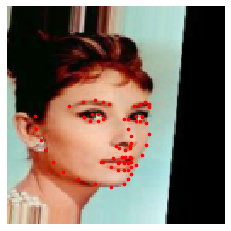

In [41]:
x, landmark = train_dataset[100]
plot_landmarks(x, landmark, image_size=128)

In [8]:
landmarks = [landmark for _, landmark in train_dataset]

In [9]:
def dist_to(x, target_idx):
    _, y = train_dataset[target_idx]
    return (x - y).pow(2).mean()

In [10]:
distances = list(map(lambda v: dist_to(v, 100), landmarks))

In [11]:
close_indices = np.argsort(distances)[:100]

In [12]:
closest_landmarks = [landmarks[i] for i in close_indices]

In [18]:
latent_code = 0.
with torch.no_grad():
    for idx in close_indices:
        image, landmark = train_dataset[idx]
        latent = net.encoder(image.unsqueeze(0).cuda())
        latent_code += latent
    latent_code /= len(close_indices)

In [17]:
total_code = 0.
with torch.no_grad():
    for idx in range(15000):
        image, landmark = train_dataset[idx]
        latent = net.encoder(image.unsqueeze(0).cuda())
        total_code += latent
    total_code /= 15000

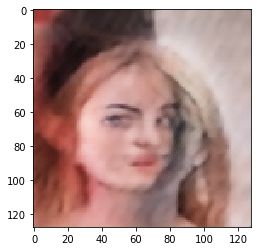

In [58]:
delta_latent = total_code - latent_code
x, landmark = train_dataset[42]
latent = net.encoder(x.unsqueeze(0).cuda())
new_latent = 0.7 * latent - 1.5 * delta_latent
reconstruction = net.decoder(new_latent).cpu().detach().squeeze()
plt.imshow(reconstruction.permute(1, 2, 0))

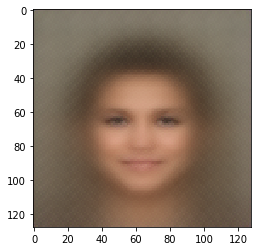

In [31]:
reconstruction = net.decoder(total_code).cpu().detach().squeeze()
plt.imshow(reconstruction.permute(1, 2, 0))

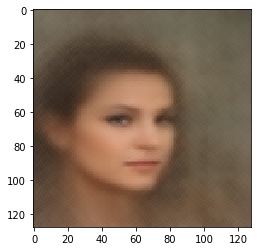

In [32]:
reconstruction = net.decoder(latent_code).cpu().detach().squeeze()
plt.imshow(reconstruction.permute(1, 2, 0))

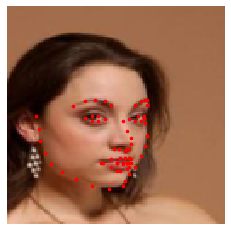

In [25]:
x, landmark = train_dataset[10040]
plot_landmarks(x, landmark, image_size=128)

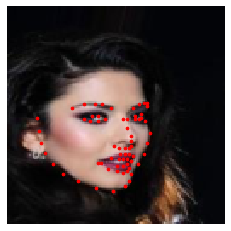

In [26]:
x, landmark = train_dataset[9935]
plot_landmarks(x, landmark, image_size=128)